In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from mlxtend.data import loadlocal_mnist
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [13]:
def Pca(data, components):
    data = data.T
    mean = np.mean(data, axis = 0)
    average_data = (data - mean)
    covarience = 1 /  len(average_data) * average_data@average_data.T
    eigen_vectors,v,d = np.linalg.svd(covarience)
    Keigen_vectors = eigen_vectors[:,:components]
    eigen_faces = Keigen_vectors.T@average_data
    return eigen_faces.T
def Accuracy(actual, predict):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predict[i]:
            correct += 1
    return correct / len(actual) * 100

In [30]:
data = pd.read_csv('ionosphere.data', header = None)
data = np.asarray(data)
X, y = data[:,:-1], data[:,-1:].flatten()
X = X.astype('float32')
# print(X)
# print(y)

In [31]:
# Reading Data

# X, y = loadlocal_mnist(images_path='train-images.idx3-ubyte',labels_path='train-labels.idx1-ubyte')
# valid = []
# for i, val in enumerate(y):
#     if val == 3 or val == 8:
#         valid.append(i)
dic = {'g':1, 'b':-1}
# X,y = X[valid], y[valid]

# print(X.shape)
y = np.asarray([dic[val] for val in y])
# pca = Pca(n_components = 10)
# X = pca.fit_transform(X)
# X = X / 255
# X = Pca(X,components=20)
rand_index = np.random.permutation(len(X))
X, y = X[rand_index], y[rand_index]
# X, y = X[:2000], y[:2000]

# 60 - 20 - 20 split into train validation and test sets

split1 = 60
split2 = 20
split_point1 = int(split1 / 100 * len(X))
split_point2 = split_point1 + int(split2 / 100 * len(X))
X_train, y_train = X[:split_point1,:], y[:split_point1]
X_val, y_val = X[split_point1:split_point2,:], y[split_point1:split_point2]
X_test, y_test = X[split_point2:,:], y[split_point2:]


In [18]:
# SVM with SMO

def linear_kernel(x1, x2):
    return x1@x2.T
def polynomial_kernel(x1, x2):
    return (x1@x2.T+1)**2
def rbf_kernel(x1, x2, sigma = 1):
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * (sigma ** 2)))

def SMO(data, label, C = 1.0, kernel_type = 'linear', rbf_sigma = 1):
    samples, features = data.shape
    alpha = np.zeros(samples)
    if kernel_type == 'linear':
        kernel = linear_kernel
    if kernel_type == 'polynomial':
        kernel = polynomial_kernel
    if kernel_type == 'rbf':
        kernel = rbf_kernel
    current_iteration = 0
    W = 0
    B = 0
    passes = 0
    max_passes = 4
    tol = 0.0001
    while passes < max_passes and current_iteration < 200:
        current_iteration += 1
        alpha_old = np.copy(alpha)
        changes = 0
        for i in range(samples):
            W = data.T@(alpha_old*label)
            Error_i = np.sign(W.T@data[i] + B) - label[i]
            if not (((label[i]*Error_i < -tol) and (alpha[i] < C)) or ((label[i]*Error_i > tol))):
                continue
            j = i
            while j == i:
                j = random.randint(0, samples-1)
            #print(data[i].shape, np.max(data[i]))
            eta = 2 * kernel(data[i], data[j]) - kernel(data[i], data[i]) - kernel(data[j], data[j])
            #print(eta)
            if eta == 0:
                continue
            if(label[i] != label[j]):
                L = max(0, alpha[j] - alpha[i])
                H = min(C, C - alpha[i] + alpha[j])
            else:
                L = max(0, alpha[i] + alpha[j] - C)
                H = min(C, alpha[i] + alpha[j])
            if L == H:
                continue
            Error_j = np.sign(W.T@data[j] + B) - label[j]
            alpha[j] = alpha_old[j] - label[j] * (Error_i - Error_j)/ eta
            if alpha[j] > H:
                alpha[j] = H
            if alpha[j] < L:
                alpha[j] = L
            #print(alpha[j], alpha_old[j], eta)
            if abs(alpha[j] - alpha_old[j]) < 0.00001:
                alpha[j] = alpha_old[j]
                continue
            alpha[i] = alpha_old[i] + label[i]*label[j] * (alpha_old[j] - alpha[j])
            b1 = B - Error_i - label[i]*(alpha[i] - alpha_old[i]) * kernel(data[i], data[i]) - label[j]*(alpha[j] - alpha_old[j]) * kernel(data[i], data[j])
            b2 = B - Error_j - label[i]*(alpha[i] - alpha_old[i]) * kernel(data[i], data[j]) - label[j]*(alpha[j] - alpha_old[j]) * kernel(data[j], data[j])
            if alpha[i] > 0 and alpha[i] < C:
                B = b1
            elif alpha[j] > 0 and alpha[j] < C:
                B = b2
            else:
                B = (b1 + b2) / 2
            changes += 1
        if changes == 0:
            passes += 1
        else:
            passes = 0
        diff = np.linalg.norm(alpha - alpha_old)
        print('Iteration : ', current_iteration , ', Difference : ' , diff, ', Changes : ', changes)
    W = data.T@(alpha * label)
    B = np.mean(label - W.T@data.T)
    return W, B, current_iteration

def predict(data, W, B, threshhold = 0):
    if threshhold == 0:
        return np.sign(W.T@data.T + B)
    result = W.T@data.T + B
    ret = []
    for val in result:
        if val >= threshhold:
            ret.append(1)
        else:
            ret.append(-1)
    return np.array(ret)

In [19]:
# C_vals = np.arange(0.1, 1.1, 0.1)
# print(C_vals)
# for val in C_vals:
W, B, iters = SMO(X_train, y_train, C = 2, kernel_type='linear')
#     Y_valid = predict(X_val, W, B)
#     print( 'Sigma : ', val, 'Validation Accuracy : ', Accuracy(y_val, Y_valid) ,'%', ', Iterations : ', iters)

Iteration :  1 , Difference :  1.8963999780859062 , Changes :  47
Iteration :  2 , Difference :  2.6407597337489253 , Changes :  32
Iteration :  3 , Difference :  1.1597399241642878 , Changes :  25
Iteration :  4 , Difference :  1.220436944531371 , Changes :  20
Iteration :  5 , Difference :  1.230616585143151 , Changes :  17
Iteration :  6 , Difference :  1.2553397038249239 , Changes :  15
Iteration :  7 , Difference :  1.184382400845913 , Changes :  16
Iteration :  8 , Difference :  1.0189260513674914 , Changes :  11
Iteration :  9 , Difference :  1.1193257171280797 , Changes :  12
Iteration :  10 , Difference :  0.9334956974887594 , Changes :  13
Iteration :  11 , Difference :  0.972609742706153 , Changes :  9
Iteration :  12 , Difference :  0.6476681120635827 , Changes :  11
Iteration :  13 , Difference :  0.5885284756065076 , Changes :  11
Iteration :  14 , Difference :  0.6413886596595374 , Changes :  12
Iteration :  15 , Difference :  0.6080211547780223 , Changes :  8
Iteration 

In [20]:
Y_valid = predict(X_val, W, B)
print('Validation Accuracy : ', Accuracy(y_val, Y_valid) ,'%')


Validation Accuracy :  88.57142857142857 %


In [21]:
Y_test = predict(X_test, W, B)
print('Test Accuracy : ',Accuracy(y_test, Y_test), '%')

Test Accuracy :  76.05633802816901 %


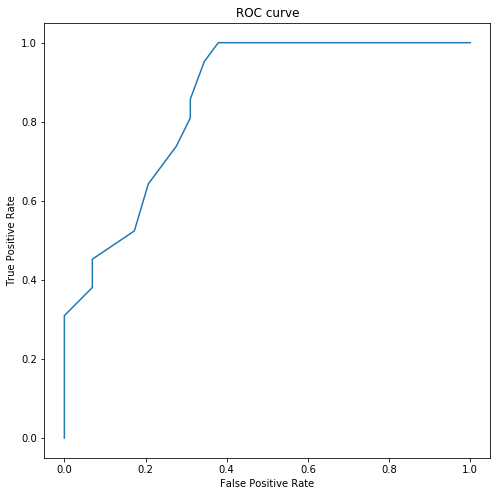

In [22]:
# ROC curve
def GetTPRandFPR(predicted, actual):
    confusion_matrix = np.zeros((2,2))
    for i in range(len(predicted)):
        if(actual[i] == -1):
            if predicted[i] == -1:
                confusion_matrix[0][0] += 1
            if predicted[i] == 1:
                confusion_matrix[0][1] += 1
        else:
            if predicted[i] == -1:
                confusion_matrix[1][0] += 1
            if predicted[i] == 1:
                confusion_matrix[1][1] += 1
#     print(confusion_matrix)
    TPR = confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[1][0])
    FPR = confusion_matrix[0][1] / (confusion_matrix[0][1] + confusion_matrix[0][0])
    return TPR, FPR

threshholds = np.arange(-500, 500, 1)
X_plot = []
Y_plot = []
# GetTPRandFPR(predict(X_test, W, B, 0),y_test)
for val in threshholds:
    TPR, FPR = GetTPRandFPR(predict(X_test, W, B, val),y_test)
    X_plot.append(FPR)
    Y_plot.append(TPR)

plt.figure(figsize=(8,8))
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(X_plot,Y_plot)